In [1]:
import sys
sys.path.append("//anaconda/envs/azureml_py38/bin/python")
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast, BertForMaskedLM, BertConfig, AdamW
from transformers import DataCollatorForLanguageModeling
from tokenizers import BertWordPieceTokenizer
from datasets import load_dataset
import os
from datetime import datetime
import os
import matplotlib.pyplot as plt
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

/anaconda/envs/llm-rag-embeddings/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 경로 설정 : 데이터를 읽어오는 곳
    
path = "/home/azureuser/cloudfiles/code/Users/hb.suh/사출성형/tokenizer_data/"

all_texts = []

# 폴더 내의 모든 txt 파일의 데이터를 모음
for file in os.listdir(path):
    if file.endswith('.txt'):
        file_path = os.path.join(path, file)
        with open(file_path, 'r', encoding='utf-8') as f:
            all_texts.append(f.read())

file_paths = [os.path.join(path, file) for file in os.listdir(path) if file.endswith('.txt')] #list


# 데이터셋 로드
dataset = load_dataset('text', data_files=file_paths, cache_dir='/home/azureuser/cloudfiles/code/Users/hb.suh/cache')

In [3]:
from tokenizers import BertWordPieceTokenizer

# BertWordPieceTokenizer 인스턴스 생성
tokenizer = BertWordPieceTokenizer(clean_text=True, handle_chinese_chars=True, strip_accents=False, lowercase=False, wordpieces_prefix="##")

# 훈련하기
tokenizer.train(
    file_paths,
    vocab_size=10000,
    min_frequency=10,
    show_progress=True,
    special_tokens = ["[PAD]", "[CLS]", "[UNK]", "[SEP]", "[MASK]"],
    wordpieces_prefix="##",
)


# 저장할 디렉토리 경로    
save_path = "/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/0508test_bertwordpiece"

# 디렉토리가 없으면 생성
if not os.path.exists(save_path):
    os.makedirs(save_path)

# 토크나이저 모델 저장
tokenizer.save_model(save_path)

# from tokenizers import ByteLevelBPETokenizer

# # ByteLevelBPETokenizer 인스턴스 생성
# tokenizer = ByteLevelBPETokenizer()

# # 훈련하기
# tokenizer.train(
#     files=file_paths,  # 훈련할 텍스트 파일 경로 리스트
#     vocab_size=10000,  # 어휘 사전의 최대 크기
#     min_frequency=10,  # 토큰이 어휘 사전에 포함되기 위한 최소 빈도
#     show_progress=True,  # 진행 상황 표시
#     special_tokens=["[PAD]", "[CLS]", "[UNK]", "[SEP]", "[MASK]"]  # 특수 토큰 추가
# )

# # 저장할 디렉토리 경로
# save_path = "/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/0508test_bertwordpiece"

# # 디렉토리가 없으면 생성
# if not os.path.exists(save_path):
#     os.makedirs(save_path)

# # tokenizer 모델 저장
# tokenizer.save_model(save_path)



['/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/0508test_bertwordpiece/vocab.txt']

In [5]:
#vocab_file_path = "/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/vocab.txt"

# 새로운 토크나이저 로드
new_tokenizer = BertTokenizerFast.from_pretrained('beomi/kcbert-base')
model = BertForMaskedLM.from_pretrained('beomi/kcbert-base')
len(new_tokenizer)

new_tokens_added = 0
new_vocab = {}  # 새로운 토큰과 아이디를 담을 딕셔너리

path = "/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/0508test_bertwordpiece/vocab.txt"
# 기존의 토크나이저 vocab에서 새로운 토큰들을 제외하고 아이디 부여
with open(path, 'r', encoding='utf-8') as f:
    for line in f:
        token = line.strip()  # 줄바꿈 문자를 제거하여 토큰만 가져옴
        if token not in new_tokenizer.get_vocab():
            new_tokenizer.add_tokens(token)
            new_tokens_added += 1
            new_vocab[token] = len(new_tokenizer) - 1  # 새로운 토큰에 새로운 아이디 부여

        else:
            # 토큰이 이미 존재하면, 기존 ID 사용
            new_vocab[token] = new_tokenizer.convert_tokens_to_ids(token)

print("new_tokens_added : ", new_tokens_added)
print(len(new_tokenizer))

# 토크나이저 모델 파일 저장
tokenizer_model_path = "/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/0508test_bertwordpiece"
new_tokenizer.save_pretrained(tokenizer_model_path)

len(new_tokenizer)

print(f"Added {new_tokens_added} new tokens")

#  vocab.txt 또는 tokenizer.json 파일 중 하나만 있어도 토크나이저를 성공적으로 로드하고 사용할 수 있습니다. 

# # 새로운 토큰과 아이디를 vocab.txt 파일에 저장
# with open(tokenizer_model_path + "/vocab.txt", 'a', encoding='utf-8') as lf:
#     for token, idx in new_vocab.items():
#         lf.write(f"{token}\t{idx}\n")

# print(f"Added {new_tokens_added} new tokens")

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


new_tokens_added :  6196
36196
Added 6196 new tokens


TEST

In [6]:

from transformers import BertTokenizerFast
# 토큰화에 사용된 토큰라이저를 로드
tokenizer = BertTokenizerFast.from_pretrained("/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/0508test_bertwordpiece/", do_lower_case=False)

def tokenize_data(tokenizer, dataset):
    def tokenize_function(examples):
        # tokenizer의 결과에서 'input_ids'와 'attention_mask'만 반환하도록 수정 #128
        tokenized_output = tokenizer(examples['text'], max_length=300, truncation=True, padding="max_length", return_tensors="pt")
        return {'input_ids': tokenized_output['input_ids'], 'attention_mask': tokenized_output['attention_mask']}
    return dataset.map(tokenize_function, batched=True, remove_columns=['text'])
    
train_dataset = dataset['train']
tokenized_datasets = tokenize_data(tokenizer, train_dataset)



# 이미 토큰화된 데이터셋을 불러옵니다. 예를 들어, 이전 단계에서 정의한 `tokenized_datasets` 변수 사용
# 토큰화된 데이터셋의 일부 샘플을 추출합니다.
samples = tokenized_datasets.shuffle(seed=42).select(range(5))  # 5개의 무작위 샘플을 추출



# 각 샘플에 대해 토큰 ID와 디코딩된 텍스트를 출력
for i, sample in enumerate(samples):
    input_ids = sample['input_ids']
    print(f"Sample {i+1} -- Input IDs: {input_ids}")
    decoded_text = tokenizer.decode(input_ids)
    print(f"Decoded Text: {decoded_text}\n")

# 이 코드는 데이터셋이 이미 메모리에 로드되어 있어야 하며, `select` 및 `shuffle` 메소드를 사용할 수 있는 상황이어야 합니다.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Sample 1 -- Input IDs: [2, 8436, 15, 24258, 9810, 4008, 30894, 33989, 20277, 4113, 11212, 10302, 17283, 1463, 27195, 17, 32102, 30126, 9679, 32387, 12197, 11017, 15, 33605, 1476, 15705, 25294, 12091, 13001, 8455, 30630, 31262, 30327, 12905, 8422, 17, 10384, 15, 30630, 22664, 4113, 8738, 21837, 30126, 30678, 30299, 8215, 8422, 17, 17026, 8122, 15, 30972, 30302, 30630, 9961, 15, 21837, 30419, 31331, 30862, 9846, 8455, 21837, 33138, 9846, 8021, 8422, 17, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [7]:
# 2. 데이터셋 토큰화

def tokenize_data(tokenizer, dataset):
    def tokenize_function(examples):
        # tokenizer의 결과에서 'input_ids'와 'attention_mask'만 반환하도록 수정 #128
        tokenized_output = tokenizer(examples['text'], max_length=300, truncation=True, padding="max_length", return_tensors="pt")
        return {'input_ids': tokenized_output['input_ids'], 'attention_mask': tokenized_output['attention_mask']}
    return dataset.map(tokenize_function, batched=True, remove_columns=['text'])

    

def resize_and_initialize_embeddings(model, tokenizer, old_tokenizer=None):
    # 모델의 원래 토큰 임베딩 크기
    original_num_tokens = model.config.vocab_size if old_tokenizer is None else len(old_tokenizer)
    
    # 새 토크나이저에 따른 임베딩 크기 조정
    new_num_tokens = len(tokenizer)
    model.resize_token_embeddings(new_num_tokens)

    # 임베딩 레이어에 접근
    embeddings = model.get_input_embeddings()
    
    # 새로운 토큰이 추가되었을 경우
    if new_num_tokens > original_num_tokens:
        # 기존 임베딩의 평균과 표준편차 계산
        with torch.no_grad():
            old_embeddings = embeddings.weight[:original_num_tokens]
            mean, std = old_embeddings.mean(dim=0), old_embeddings.std(dim=0)
            # 새로운 토큰의 임베딩 초기화
            new_embeddings = torch.randn(new_num_tokens - original_num_tokens, embeddings.embedding_dim)
            new_embeddings = mean + std * new_embeddings
            embeddings.weight[original_num_tokens:] = new_embeddings

    return model

# import torch.nn as nn
# import torch
# # def resize_and_initialize_embedding_matrix(model, tokenizer, emb_mtx_name='bert.embeddings.word_embeddings.weight'):


# after_add_Trained_Tokenizer = BertTokenizerFast.from_pretrained("/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/TEST_bertwordpiece/")
# emb_mtx_name='bert.embeddings.word_embeddings.weight'
# # 모델의 원래 토큰 임베딩 크기
# num_orig_tokens = model.config.vocab_size

# # 새 토크나이저에 따른 임베딩 크기 조정
# new_num_tokens = len(after_add_Trained_Tokenizer)
# model.resize_token_embeddings(new_num_tokens)

# #########################################################
# # 임베딩 레이어의 현재 크기 확인
# current_embedding_shape = model.get_input_embeddings().weight.size()
# print("Current embedding shape:", current_embedding_shape)

# # 조정된 크기와 예상 크기 비교
# expected_shape = (new_num_tokens, model.config.hidden_size)
# print("Expected embedding shape:", expected_shape)
# #########################################################


# # emb_mtx_name을 '.'을 기준으로 분할하여 각 부분을 참조
# parts = emb_mtx_name.split('.')

# # parts 리스트를 사용하여 모델에서 원하는 객체를 순차적으로 얻음
# embedding_layer = model
# for part in parts[:-1]:  # 마지막 부분(weight)은 제외하고 객체를 얻음
#     embedding_layer = getattr(embedding_layer, part)

# # embeddings 변수는 이미 임베딩 레이어를 참조
# embeddings = embedding_layer
# old_num_embeddings, embedding_dim = embeddings.weight.size()

# # 새로운 임베딩 레이어 생성
# new_embedding_layer = nn.Embedding(new_num_tokens, embedding_dim)

# # 기존 임베딩 레이어의 가중치를 새 레이어에 복사
# with torch.no_grad():
#     new_embedding_layer.weight[:old_num_embeddings] = embeddings.weight

# # 추가된 토큰 수 계산
# num_added_tokens = new_num_tokens - old_num_embeddings

# # 기존 임베딩의 통계치를 이용하여 새로운 임베딩 초기화
# if num_added_tokens > 0:
#     pre_expansion_embeddings = embeddings.weight[:num_orig_tokens, :]
#     mu = pre_expansion_embeddings.mean(dim=0)
#     std = pre_expansion_embeddings.std(dim=0)

#     with torch.no_grad():
#         new_embedding_layer.weight[old_num_embeddings:] = mu +  std * torch.randn(num_added_tokens, embedding_dim)

# # 새로운 임베딩 레이어로 모델 업데이트
# setattr(embedding_layer, 'weight', new_embedding_layer.weight)

# #return model




###############################################################
after_add_Trained_Tokenizer = BertTokenizerFast.from_pretrained("/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/0508test_bertwordpiece/",do_lower_case=False)

model = resize_and_initialize_embeddings(model, after_add_Trained_Tokenizer )
#model = resize_and_initialize_embedding_matrix(model, after_add_Trained_Tokenizer,emb_mtx_name='bert.embeddings.word_embeddings.weight')
print(len(after_add_Trained_Tokenizer))


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


36196


Map: 100%|██████████| 942/942 [00:09<00:00, 95.28 examples/s]


Epoch 1 completed, Loss: 5.416138172149658, Current LR: 1.1227600849256998e-06
Epoch 2 completed, Loss: 5.624236106872559, Current LR: 1.2455201698513996e-06
Epoch 3 completed, Loss: 5.355045318603516, Current LR: 1.3682802547770558e-06
Epoch 4 completed, Loss: 5.138874053955078, Current LR: 1.4910403397027556e-06
Epoch 5 completed, Loss: 4.933863162994385, Current LR: 1.6138004246284554e-06
Epoch 6 completed, Loss: 5.288161754608154, Current LR: 1.7365605095541552e-06
Epoch 7 completed, Loss: 4.97595739364624, Current LR: 1.8593205944798116e-06
Epoch 8 completed, Loss: 5.589491844177246, Current LR: 1.982080679405511e-06
Epoch 9 completed, Loss: 5.293214797973633, Current LR: 2.104840764331211e-06
Epoch 10 completed, Loss: 4.690286159515381, Current LR: 2.2276008492569107e-06
Epoch 11 completed, Loss: 5.132070064544678, Current LR: 2.3503609341826105e-06
Epoch 12 completed, Loss: 5.292284965515137, Current LR: 2.473121019108267e-06
Epoch 13 completed, Loss: 4.534366130828857, Current 

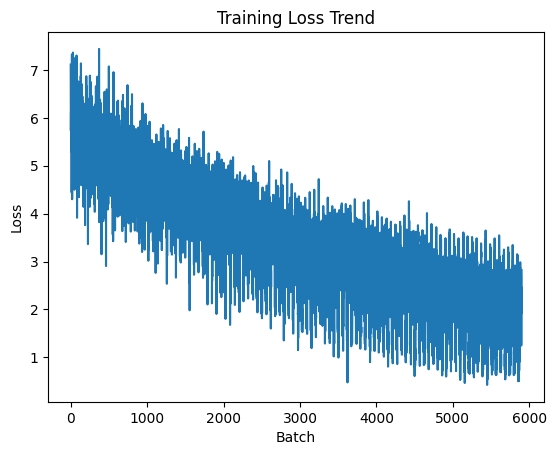

36196


In [34]:
from transformers import get_linear_schedule_with_warmup

def train_model(model, train_dataset, tokenizer, EPOCH, early_stopping_patience = None):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # 옵티마이저와 스케줄러를 설정합니다.
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
    total_steps = len(train_dataset) * EPOCH 
    
    # 학습률이 주기적으로 높아졌다가 낮아지도록 설정되며, 
    # 처음에는 낮은 학습률에서 시작하여 점차 학습률을 높인 뒤 다시 낮추는 방식으로 진행
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                                  base_lr=1e-6,  # 최소 학습률
                                                  max_lr=5e-5,  # 최대 학습률
                                                  step_size_up=total_steps // 4,  # 학습률이 증가하는 스텝 수
                                                  step_size_down=total_steps - total_steps // 4,  # 감소하는 스텝 수
                                                  mode='triangular',
                                                  cycle_momentum=False)  # 'triangular', 'triangular2' 또는 'exp_range'
    
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)
    train_loader = DataLoader(train_dataset, batch_size=16, collate_fn=data_collator)
    model.train()

    losses = []
    best_loss = float('inf')
    patience_counter = 0  # for the early stopping

    for epoch in range(EPOCH):

        epoch_losses = []  

        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            
            loss.backward()
            
            # 그라디언트 클리핑을 적용하여 그라디언트 폭발을 방지합니다.
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()  # 학습률을 업데이트합니다.
            optimizer.zero_grad()

            epoch_losses.append(loss.item())  # 현재 배치의 loss 값을 저장

        # 현재 epoch의 평균 loss 값을 계산하여 출력
        epoch_loss_mean = sum(epoch_losses) / len(epoch_losses)
        print(f"Epoch {epoch + 1} completed, Loss: {loss.item()}, Current LR: {scheduler.get_last_lr()[0]}")
        losses.extend(epoch_losses)

        # early stopping 체크
        if epoch_loss_mean < best_loss:
            best_loss = epoch_loss_mean
            patience_counter = 0  # 성능이 개선되면 카운터 초기화
        else:
            patience_counter += 1  # 성능이 개선되지 않으면 카운터 증가

        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch + 1} as no improvement in loss.")
            break


    # Loss 함수 시각화
    plt.plot(losses)
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Training Loss Trend')
    plt.show()

    return model



def save_model(model, tokenizer, pretrained_model_name):

    safe_model_name = pretrained_model_name.replace("/", "-")
    # 현재 날짜와 시간을 포함한 디렉토리 이름을 생성
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    directory = f"/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/MLM_trained_model/{safe_model_name}_CyclicLRtriangular-{timestamp}"

    # 디렉토리가 존재하지 않으면 생성
    if not os.path.exists(directory):
        os.makedirs(directory)

    # 모델과 토크나이저를 사전 훈련된 디렉토리에 저장
    model.save_pretrained(directory)
    tokenizer.save_pretrained(directory)


train_dataset = dataset['train']
tokenized_datasets = tokenize_data(after_add_Trained_Tokenizer, train_dataset)

# 모델 학습 
model = train_model(model, tokenized_datasets, after_add_Trained_Tokenizer , 100, early_stopping_patience=5)

print(len(after_add_Trained_Tokenizer))

# 모델 저장
save_model(model, after_add_Trained_Tokenizer, "kcbert-base")

- 기본 : 98 epoch, 0.079
- 표준편차를 조정 : 30 epoch, 0.093
- weights freeze 시키면 : 20 epoch , 0.136295
- 레퍼런스 코드 따라한 기본: 188 epoch , 0.07938

## for test

토큰학습

토큰 추가 후 최종 토크나이저

In [35]:
from transformers import BertTokenizerFast
text = '  공정변수를 진공성형의 사출성형해석에 요인배치로써 공급부에 중요한 역할을 제공한다. '
tokenizer =BertTokenizerFast.from_pretrained("/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/0508test_bertwordpiece/",do_lower_case=False)
# 텍스트 토큰화
tokenized_output = tokenizer.encode(text, add_special_tokens=False)
print(tokenized_output)
print("tokenizer len:",len(tokenizer))
# 토큰화 결과 출력
for output in tokenized_output:
    decoded_output = tokenizer.decode(output)
    print("Decoded Text:", decoded_output)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[34904, 31027, 33480, 30994, 2255, 31029, 17238, 14639, 11144, 15328, 10302, 17572, 13248, 8008, 17]
tokenizer len: 36196
Decoded Text: 공정변수를
Decoded Text: 진공
Decoded Text: 성형의
Decoded Text: 사출성형해석
Decoded Text: 에
Decoded Text: 요인
Decoded Text: 배치
Decoded Text: ##로써
Decoded Text: 공급
Decoded Text: ##부에
Decoded Text: 중요한
Decoded Text: 역할을
Decoded Text: 제공
Decoded Text: ##한다
Decoded Text: .


In [14]:
from transformers import BertTokenizer

text = ["공정변수가 진공성형의 사출성형해석에 요인배치로써 공급부에 중요한 역할을 제공한다."]
tokenizer = BertTokenizer.from_pretrained('/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/bertwordpiece', do_basic_tokenize=False)
# 텍스트 토큰화
tokenized_output = tokenizer.encode(str(text), add_special_tokens=True)
print(tokenized_output)

# 토큰화 결과 출력
for output in tokenized_output:
    decoded_output = tokenizer.decode(output, skip_special_tokens=True)
    print("Decoded Text:", decoded_output)

[2, 1, 1, 1785, 4208, 4093, 4572, 4032, 27667, 1, 1, 10302, 17572, 1, 3]
Decoded Text: [ C L S ]
Decoded Text: [ U N K ]
Decoded Text: [ U N K ]
Decoded Text: 사
Decoded Text: # # 출
Decoded Text: # # 성
Decoded Text: # # 형
Decoded Text: # # 해
Decoded Text: # # 석 에
Decoded Text: [ U N K ]
Decoded Text: [ U N K ]
Decoded Text: 중 요 한
Decoded Text: 역 할 을
Decoded Text: [ U N K ]
Decoded Text: [ S E P ]


In [20]:
from transformers import BertTokenizerFast
text = '  공정변수를 진공성형의 사출성형해석에 요인배치로써 공급부에 중요한 역할을 제공한다. '
tokenizer =BertTokenizerFast.from_pretrained("/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/0508test_bertwordpiece/",do_lower_case=False)
# 텍스트 토큰화
tokenized_output = tokenizer.encode(text, add_special_tokens=False)
print(tokenized_output)
print("tokenizer len:",len(tokenizer))
# 토큰화 결과 출력
for output in tokenized_output:
    decoded_output = tokenizer.decode(output)
    print("Decoded Text:", decoded_output)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[34904, 31027, 33480, 30994, 2255, 31029, 17238, 14639, 11144, 15328, 10302, 17572, 13248, 8008, 17]
tokenizer len: 36196
Decoded Text: 공정변수를
Decoded Text: 진공
Decoded Text: 성형의
Decoded Text: 사출성형해석
Decoded Text: 에
Decoded Text: 요인
Decoded Text: 배치
Decoded Text: ##로써
Decoded Text: 공급
Decoded Text: ##부에
Decoded Text: 중요한
Decoded Text: 역할을
Decoded Text: 제공
Decoded Text: ##한다
Decoded Text: .


In [10]:
# 새 토큰의 ID 확인
token_id = tokenizer.convert_tokens_to_ids("공정변수")
print("Token ID for '공정변수':", token_id)

# 직접 인코딩과 디코딩을 통한 검증
encoded_text = tokenizer.encode("공정변수", add_special_tokens=False)
decoded_text = tokenizer.decode(encoded_text)
print("Encoded and Decoded Text:", decoded_text)

Token ID for '공정변수': 31021
Encoded and Decoded Text: 공정변수


In [13]:
test_str = ' [CLS] 공정변수를 진공성형의 사출성형해석에 요인배치로써 공급부에 중요한 역할을 제공한다. [SEP]'
print('테스트 문장: ',test_str)

encoded_str = tokenizer.encode(test_str,add_special_tokens=False)
print('문장 인코딩: ',encoded_str)

decoded_str = tokenizer.decode(encoded_str)
print('문장 디코딩: ',decoded_str)

테스트 문장:   [CLS] 공정변수를 진공성형의 사출성형해석에 요인배치로써 공급부에 중요한 역할을 제공한다. [SEP]
문장 인코딩:  [2, 34904, 31027, 33480, 30994, 2255, 31029, 17238, 14639, 11144, 15328, 10302, 17572, 13248, 8008, 17, 3]
문장 디코딩:  [CLS] 공정변수를 진공 성형의 사출성형해석 에 요인 배치로써 공급부에 중요한 역할을 제공한다. [SEP]


In [5]:
tokenizer = BertTokenizerFast.from_pretrained("/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/0508test_bertwordpiece/")
def chunk_text(text, chunk_size=5100):
    token_ids = tokenizer.encode(text, add_special_tokens=False)  # 특수 토큰을 제외하고 인코딩
    return [token_ids[i:i + chunk_size] for i in range(0, len(token_ids), chunk_size)]

# 예시 텍스트
text = "공정변수를 진공성형의 사출성형해석에 요인배치로써 공급부에 중요한 역할을 제공한다."

# 텍스트를 청크로 나누기
chunks = chunk_text(text)

# 각 청크를 별도로 처리
for chunk in chunks:
    inputs = tokenizer.decode(chunk, skip_special_tokens=True)  # 토큰 ID를 다시 텍스트로 디코드
    print(inputs)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


사출성형해석 에 중요한 역할을 제공한다.


## vocab add 안하고 우리 데이터로 학습만 한 토크나이저 결과

In [31]:
from transformers import BertTokenizer

text = ' [CLS] 공정변수를 진공성형의 사출성형해석에 요인배치로써 공급부에 중요한 역할을 제공한다. [SEP]'
tokenizer = BertTokenizer("/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/CUSTOM_Tokenizer/vocab.txt",do_lower_case=False)
#tokenizer =BertTokenizerFast.from_pretrained("/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/0508test_bertwordpiece/vocab.txt",do_lower_case=False)# 텍스트 토큰화
tokenized_output = tokenizer.encode(text, add_special_tokens=False)
print(tokenized_output)

print("tokenizer len:",len(tokenizer))
# 토큰화 결과 출력
for output in tokenized_output:
    decoded_output = tokenizer.decode(output)
    print("Decoded Text:", decoded_output)


[1, 8456, 14466, 1040, 14881, 14467, 5104, 14469, 1073, 2768, 3854, 11219, 18, 3]
tokenizer len: 30000
Decoded Text: [ C L S ]
Decoded Text: 공 정 변 수 를
Decoded Text: 진 공 성 형
Decoded Text: # # 의
Decoded Text: 사 출 성 형 해 석 에
Decoded Text: 요 인 배 치
Decoded Text: # # 로 써
Decoded Text: 공 급 부
Decoded Text: # # 에
Decoded Text: 중 요 한
Decoded Text: 역 할 을
Decoded Text: 제 공 한 다
Decoded Text: .
Decoded Text: [ S E P ]


In [9]:
tokenizer.get_vocab()

{'우수하여': 13450,
 '작동': 3975,
 '영업': 7323,
 '##되어있다': 18397,
 'ASME': 10102,
 '##FRP': 26927,
 '##ences': 4572,
 '##92': 10148,
 '냉각효율을': 22847,
 '나가는': 25020,
 'Seo': 8274,
 '##인공신경망': 24749,
 '론본': 4401,
 'Noh': 15645,
 '##oving': 6388,
 '신흥': 26734,
 '##문의': 20647,
 'HIPS': 7829,
 '19': 1984,
 '##펜': 1645,
 '##치면서': 26958,
 'prepar': 6736,
 '301': 14053,
 'only': 6764,
 '제조하는': 7518,
 'stationary': 16886,
 '수치해석의': 29667,
 '##oost': 27404,
 '이축': 25112,
 '10°C': 12635,
 '4번': 19516,
 '##alled': 9686,
 '균형을': 8550,
 '평균휘도': 27375,
 '##약적인': 28888,
 '##echn': 2251,
 '포함하여': 9807,
 'defined': 11405,
 '고강도': 13891,
 '분석된다': 14027,
 '함유된': 9704,
 '##밸브': 4778,
 'hy': 3769,
 'Che': 6278,
 '가스채널을': 9152,
 '인수': 13314,
 '입구에서의': 22109,
 '이내': 8965,
 '회사': 7276,
 '수리': 12560,
 '440': 18079,
 '9월에': 28290,
 '##08': 28776,
 '##Engineers': 13092,
 'd1': 19565,
 '직전의': 26800,
 '65MPa': 24392,
 'dec': 3894,
 'Viscoelastic': 13003,
 '높': 303,
 'image': 5299,
 '사슬의': 23423,
 'Lines': 24897,
 'rem': 

In [2]:
from tokenizers import BertWordPieceTokenizer

# 어휘 사전 파일 확인
vocab_path = "/home/azureuser/cloudfiles/code/Users/hb.suh/OUR_BERT/trained_tokenizer/CUSTOM_Tokenizer/vocab.txt"
tokenizer = BertWordPieceTokenizer(vocab_path)
print(tokenizer)

# text = "공정변수를 진공성형의 사출성형해석에 요인배치로써 공급부에 중요한 역할을 제공한다."
# # 텍스트 토큰화
# tokenized_output = tokenizer.encode(text, add_special_tokens=True)
# print("Token IDs:", tokenized_output.ids)
# print("Tokens:", tokenized_output.tokens)
# # 토큰 ID 배열을 사용하여 전체 텍스트 디코딩
# decoded_text = tokenizer.decode(tokenized_output.ids)
# print("Decoded Text:", decoded_text)


Tokenizer(vocabulary_size=30000, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)
